# Exposures class

## Content

- [Defining exposuresfrom your owndata](#Defining-exposures-from-your-own-data) 
- [Loading CLIMADA generated exposure files or generating new ones](#Loading-CLIMADA-generated-exposure-files-or-generating-new-ones)
- [Visualize Exposures](#Visualize-Exposures)
- [Write (Save) Exposures](#Write-(Save)-Exposures)
- [Dask: improving performance for big exposure](#Dask---improving-performance-for-big-exposure)


### What is an exposure?

Exposure describes the set of assets, people, livelihoods, infrastructures, etc. within an area of interest in terms of their geographic location, their value etc.; in brief - everything potentially exposed to hazards. 



### What options does CLIMADA offer for me to create an exposure?

CLIMADA has an `Exposures` class for this purpuse. An `Exposures` instance can be filled with your own data, or loaded from available default sources implemented through some Exposures-type classes from CLIMADA. <br>
If you have your own data, they can be provided in the formats of a `pandas.DataFrame`, a `geopandas.GeoDataFrame` or simply an `Excel` file. 
If you didn't collect your own data, exposures can be generated on the fly using CLIMADA's [LitPop](climada_entity_LitPop.ipynb),  [BlackMarble](https://climada-petals.readthedocs.io/en/stable/tutorial/climada_entity_BlackMarble.html) or  [OpenStreetMap](https://climada-petals.readthedocs.io/en/stable/tutorial/climada_exposures_openstreetmap.html) modules. See the respective tutorials to learn what exactly they contain and how to use them.



### What does an exposure look like in CLIMADA?

An exposure is represented in the class `Exposures`, which contains a [geopandas](https://geopandas.readthedocs.io/en/latest/gallery/cartopy_convert.html) [GeoDataFrame](https://geopandas.readthedocs.io/en/latest/docs/user_guide/data_structures.html#geodataframe) that is accessible through the `Exposures` `gdf` attribute.
Certain columns of `gdf` _have to_ be specified, while others are optional (this means that the package `climada.engine` also works without these variables set.) The full list looks like this:


<br>

| Mandatory columns | Data Type | Description |
| :-------------------- | :------------ | :------------------------------------------------------------------------------------- |
| `latitude` | float | latitude |
| `longitude` | float | longitude |
| `value` | float | a value for each exposure &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;|

<br>
<br>

| Optional columns | Data Type | Description |
| :-------------------- | :------------ | :------------------------------------------------------------------------------------- |
| `impf_*`  | int | impact functions ids for hazard types.<br>important attribute, since it relates the exposures to the hazard by specifying the impf_act functions.<br>Ideally it should be set to the specific hazard (e.g. `impf_TC`) so that different hazards can be set<br>in the same Exposures (e.g. `impf_TC` and `impf_FL`).<br>If not provided, set to  default `impf_` with ids 1 in check(). |
| `geometry` | Point | geometry of type Point<br>Main feature of geopandas DataFrame extension<br>Computed in method `set_geometry_points()` |
| `deductible` | float | deductible value for each exposure. <br>Used for insurance |
| `cover` | float | cover value for each exposure. <br>Used for insurance |
| `category_id` | int | category id (e.g. building code) for each exposure |
| `region_id` | int | region id (e.g. country ISO code) for each exposure |
| `impf_*` | int | centroids index for hazard type.<br>There might be different hazards defined: centr_TC, centr_FL, ...<br>Computed in method `assign_centroids()` |

<br>
<br>

| Metadata variables | Data Type | Description |
| :-------------------- | :------------ | :------------------------------------------------------------------------------------- |
| `crs` | str or int | coordinate reference system, see <a href="https://geopandas.readthedocs.io/en/latest/docs/user_guide/projections.html">GeoDataFrame.crs |
| `description` | str | describing origin and content of the exposures data |
| `ref_year` | int | reference year |
| `value_unit` | str | unit of the exposures' values |
| `meta` | dict | dictionary containing corresponding raster properties (if any):<br>width, height, crs and transform must be present at least (transform needs to contain upper left corner!).<br>Exposures might not contain all the points of the corresponding raster. |


## Defining exposures from your own data

The essential structure of an exposure is similar, irrespective of the data type you choose to provide: As mentioned in the introduction, the key variables to be provided are `latitude`s, `longitude`s and `value`s of your exposed assets. 
While not mandatory, but very useful to provide for the impact calculation at later stages: the impact function id (see `impf_*` in the table above). 
The following examples will walk you through how to specifiy those four variables, and demonstrate the use of a few more optional parameters on the go.

### Exposures from a pandas DataFrame

In case you are unfamiliar with the data structure, check out the [pandas DataFrame documentation](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.html).

In [1]:
import numpy as np
from pandas import DataFrame
from climada.entity import Exposures

# Fill a pandas DataFrame with the 3 mandatory variables (latitude, longitude, value) for a number of assets (10'000).
# We will do this with random dummy data for purely illustrative reasons:
exp_df = DataFrame()
n_exp = 100*100
# provide value
exp_df['value'] = np.arange(n_exp)
# provide latitude and longitude
lat, lon = np.mgrid[15 : 35 : complex(0, np.sqrt(n_exp)), 20 : 40 : complex(0, np.sqrt(n_exp))]
exp_df['latitude'] = lat.flatten()
exp_df['longitude'] = lon.flatten()

In [2]:
# For each exposure entry, specify which impact function should be taken for which hazard type.
# In this case, we only specify the IDs for tropical cyclone (TC); here, each exposure entry will be treated with
# the same impact function: the one that has ID '1':
# Of course, this will only be relevant at later steps during impact calculations.
exp_df['impf_TC'] = np.ones(n_exp, int)

In [3]:
# Let's have a look at the pandas DataFrame
print('\x1b[1;03;30;30m' + 'exp_df is a DataFrame:', str(type(exp_df)) + '\x1b[0m')
print('\x1b[1;03;30;30m' + 'exp_df looks like:' + '\x1b[0m')
print(exp_df.head())

exp_df is a DataFrame: <class 'pandas.core.frame.DataFrame'>
exp_df looks like:
   value  latitude  longitude  impf_TC
0      0      15.0  20.000000        1
1      1      15.0  20.202020        1
2      2      15.0  20.404040        1
3      3      15.0  20.606061        1
4      4      15.0  20.808081        1


In [4]:
# Generate Exposures from the pandas DataFrame. This step converts the DataFrame into
# a CLIMADA Exposures instance!
exp = Exposures(exp_df)
print('\n\x1b[1;03;30;30m' + 'exp has the type:', str(type(exp)))
print('and contains a GeoDataFrame exp.gdf:', str(type(exp.gdf)) + '\n\n\x1b[0m')

# set geometry attribute (shapely Points) from GeoDataFrame from latitude and longitude
exp.set_geometry_points()
print('\n' + '\x1b[1;03;30;30m' + 'check method logs:' + '\x1b[0m')

# always apply the check() method in the end. It puts metadata that has not been assigned,
# and points out missing mandatory data
exp.check()


exp has the type: <class 'climada.entity.exposures.base.Exposures'>
and contains a GeoDataFrame exp.gdf: <class 'geopandas.geodataframe.GeoDataFrame'>



check method logs:


In [5]:
# let's have a look at the Exposures instance we created!
print('\n' + '\x1b[1;03;30;30m'  + 'exp looks like:' + '\x1b[0m')
print(exp)


exp looks like:
ref_year: 2018
value_unit: USD
meta: {'crs': 'EPSG:4326'}
crs: EPSG:4326
data:
      value  latitude  longitude  impf_TC                   geometry
0         0      15.0  20.000000        1  POINT (20.00000 15.00000)
1         1      15.0  20.202020        1  POINT (20.20202 15.00000)
2         2      15.0  20.404040        1  POINT (20.40404 15.00000)
3         3      15.0  20.606061        1  POINT (20.60606 15.00000)
4         4      15.0  20.808081        1  POINT (20.80808 15.00000)
...     ...       ...        ...      ...                        ...
9995   9995      35.0  39.191919        1  POINT (39.19192 35.00000)
9996   9996      35.0  39.393939        1  POINT (39.39394 35.00000)
9997   9997      35.0  39.595960        1  POINT (39.59596 35.00000)
9998   9998      35.0  39.797980        1  POINT (39.79798 35.00000)
9999   9999      35.0  40.000000        1  POINT (40.00000 35.00000)

[10000 rows x 5 columns]


### Exposures from a geopandas GeoDataFrame

In case you are unfamiliar with with data structure, check out the [geopandas GeoDataFrame documentation](https://geopandas.readthedocs.io/en/latest/data_structures.html#geodataframe). 
The main difference to the example above (pandas DataFrame) is that, while previously, we provided latitudes and longitudes which were then converted to a `geometry` GeoSeries using the `set_geometry_points` method, GeoDataFrames alread come with a defined `geometry` GeoSeries. In this case, we take the geometry info and use the `set_lat_lon` method to explicitly provide latitudes and longitudes. 
This example focuses on data with POINT geometry, but in principle, other geometry types (such as POLYGON and MULTIPOLYGON) would work as well.

In [6]:
import numpy as np
import geopandas as gpd
from climada.entity import Exposures

# Read spatial info from an external file into GeoDataFrame
world = gpd.read_file(gpd.datasets.get_path('naturalearth_cities'))
print('\x1b[1;03;30;30m' + 'World is a GeoDataFrame:', str(type(world)) + '\x1b[0m')
print('\x1b[1;03;30;30m' + 'World looks like:' + '\x1b[0m')
print(world.head())

World is a GeoDataFrame: <class 'geopandas.geodataframe.GeoDataFrame'>
World looks like:
           name                   geometry
0  Vatican City  POINT (12.45339 41.90328)
1    San Marino  POINT (12.44177 43.93610)
2         Vaduz   POINT (9.51667 47.13372)
3    Luxembourg   POINT (6.13000 49.61166)
4       Palikir  POINT (158.14997 6.91664)


In [7]:
# Generate Exposures: value, latitude and longitude for each exposure entry.
# Convert GeoDataFrame into Exposure instance
exp_gpd = Exposures(world)
print('\n' + '\x1b[1;03;30;30m' + 'exp_gpd is an Exposures:', str(type(exp_gpd)) + '\x1b[0m')
# add random values to entries
exp_gpd.gdf['value'] = np.arange(world.shape[0])
# set latitude and longitude attributes from geometry
exp_gpd.set_lat_lon()


exp_gpd is an Exposures: <class 'climada.entity.exposures.base.Exposures'>


In [8]:
# For each exposure entry, specify which impact function should be taken for which hazard type.
# In this case, we only specify the IDs for tropical cyclone (TC); here, each exposure entry will be treated with
# the same impact function: the one that has ID '1':
# Of course, this will only be relevant at later steps during impact calculations.
exp_gpd.gdf['impf_TC'] = np.ones(world.shape[0], int)
print('\n' + '\x1b[1;03;30;30m' + 'check method logs:' + '\x1b[0m')

# as always, run check method to assign meta-data and check for missing mandatory variables.
exp_gpd.check()


check method logs:


In [9]:
# let's have a look at the Exposures instance we created!
print('\n' + '\x1b[1;03;30;30m'  + 'exp_gpd looks like:' + '\x1b[0m')
print(exp_gpd)


exp_gpd looks like:
ref_year: 2018
value_unit: USD
meta: {'crs': <Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich
}
crs: epsg:4326
data:
             name                     geometry  value   latitude   longitude  \
0    Vatican City    POINT (12.45339 41.90328)      0  41.903282   12.453387   
1      San Marino    POINT (12.44177 43.93610)      1  43.936096   12.441770   
2           Vaduz     POINT (9.51667 47.13372)      2  47.133724    9.516669   
3      Luxembourg     POINT (6.13000 49.61166)      3  49.611660    6.130003   
4         Palikir    POINT (158.14997 6.91664)      4   6.916644  158.149974   
..            ...                          ...    ...        ...         ...   
197         Cairo    POINT (31.24802 30.05191)    1

The fact that `Exposures` is built around a `geopandas.GeoDataFrame` offers all the useful functionalities that come with the package. The following examples showcase only a few of those.

In [10]:
# Example 1: extract data in a region: latitudes between -5 and 5
sel_exp = exp_gpd.copy()  # to keep the original exp_gpd Exposures data
sel_exp.gdf = sel_exp.gdf.cx[:, -5:5]

print('\n' + '\x1b[1;03;30;30m' + 'sel_exp contains a subset of the original data' + '\x1b[0m')
sel_exp.gdf.head()


sel_exp contains a subset of the original data


,name,geometry,value,latitude,longitude,impf_TC
9,Tarawa,POINT (173.01757 1.33819),9,1.338188,173.017571,1
13,Kigali,POINT (30.05859 -1.95164),13,-1.951644,30.058586,1
15,Juba,POINT (31.58003 4.82998),15,4.829975,31.580026,1
27,Bujumbura,POINT (29.36001 -3.37609),27,-3.376087,29.360006,1
48,Kampala,POINT (32.58138 0.31860),48,0.318605,32.581378,1


In [11]:
# Example 2: extract data in a polygon
from shapely.geometry import Polygon
sel_polygon = exp_gpd.copy()  # to keep the original exp_gpd Exposures data

poly = Polygon([(0, -10), (0, 10), (10, 5)])
sel_polygon.gdf = sel_polygon.gdf[sel_polygon.gdf.intersects(poly)]

# Let's have a look. Again, the sub-selection is a GeoDataFrame!
print('\n' + '\x1b[1;03;30;30m' + 'sel_exp contains a subset of the original data' + '\x1b[0m')
sel_polygon.gdf


sel_exp contains a subset of the original data


,name,geometry,value,latitude,longitude,impf_TC
36,Lome,POINT (1.22081 6.13388),36,6.133883,1.220811,1
84,Malabo,POINT (8.78328 3.75002),84,3.750015,8.783278,1
113,Cotonou,POINT (2.51804 6.40195),113,6.401954,2.518045,1
125,Sao Tome,POINT (6.73333 0.33340),125,0.333402,6.733325,1


In [12]:
# Example 3: change coordinate reference system
# use help to see more options: help(sel_exp.to_crs)
sel_polygon.to_crs(epsg=3395, inplace=True)
print('\n' + '\x1b[1;03;30;30m' + 'the crs has changed to ' +str(sel_polygon.crs))
print('the values for latitude and longitude are now according to the new coordinate system: \x1b[0m')
sel_polygon.gdf


the crs has changed to epsg:3395
the values for latitude and longitude are now according to the new coordinate system: 


,name,geometry,value,latitude,longitude,impf_TC
36,Lome,POINT (135900.088 679566.334),36,679566.333952,135900.087901,1
84,Malabo,POINT (977749.984 414955.551),84,414955.550857,977749.983897,1
113,Cotonou,POINT (280307.458 709388.810),113,709388.810160,280307.458315,1
125,Sao Tome,POINT (749550.327 36865.909),125,36865.908682,749550.327404,1


In [13]:
# Example 4: concatenate exposures
exp_all = Exposures.concat([sel_polygon, sel_exp.to_crs(epsg=3395)])

# the output is of type Exposures
print('exp_all type and number of rows:', type(exp_all), exp_all.gdf.shape[0])
print('number of unique rows:', exp_all.gdf.drop_duplicates().shape[0])

# NaNs will appear in the missing values
exp_all.gdf.head()

exp_all type and number of rows: <class 'climada.entity.exposures.base.Exposures'> 25
number of unique rows: 23


,name,geometry,value,latitude,longitude,impf_TC
0,Lome,POINT (135900.088 679566.334),36,679566.333952,1.359001e+05,1
1,Malabo,POINT (977749.984 414955.551),84,414955.550857,9.777500e+05,1
2,Cotonou,POINT (280307.458 709388.810),113,709388.810160,2.803075e+05,1
3,Sao Tome,POINT (749550.327 36865.909),125,36865.908682,7.495503e+05,1
4,Tarawa,POINT (19260227.883 147982.749),9,147982.748978,1.926023e+07,1



### Exposures of any file type supported by Geopandas and Pandas

Geopandas can read almost any vector-based spatial data format including ESRI shapefile, GeoJSON files and more, see [readers geopandas](http://geopandas.org/io.html). Pandas supports formats such as csv, html or sql; see [readers pandas](https://pandas.pydata.org/pandas-docs/stable/io.html). Using the corresponding readers, `DataFrame` and `GeoDataFrame` can be filled and provided to `Exposures` following the previous examples.


### Exposures from an excel file

If you manually collect exposure data, Excel may be your preferred option. 
In this case, it is easiest if you format your data according to the structure provided in the template  `climada_python/climada/data/system/entity_template.xlsx`, in the sheet `assets`.

In [14]:
import pandas as pd
from climada.util.constants import ENT_TEMPLATE_XLS
from climada.entity import Exposures

# Read your Excel file into a pandas DataFrame (we will use the template example for this demonstration):
file_name = ENT_TEMPLATE_XLS
exp_templ = pd.read_excel(file_name)

# Let's have a look at the data:
print('\x1b[1;03;30;30m' + 'exp_templ is a DataFrame:', str(type(exp_templ)) + '\x1b[0m')
print('\x1b[1;03;30;30m' + 'exp_templ looks like:' + '\x1b[0m')
exp_templ.head()

exp_templ is a DataFrame: <class 'pandas.core.frame.DataFrame'>
exp_templ looks like:


,latitude,longitude,value,deductible,cover,region_id,category_id,impf_TC,centr_TC,impf_FL,centr_FL
0,26.933899,-80.128799,1.392750e+10,0,1.392750e+10,1,1,1,1,1,1
1,26.957203,-80.098284,1.259606e+10,0,1.259606e+10,1,1,1,2,1,2
2,26.783846,-80.748947,1.259606e+10,0,1.259606e+10,1,1,1,3,1,3
3,26.645524,-80.550704,1.259606e+10,0,1.259606e+10,1,1,1,4,1,4
4,26.897796,-80.596929,1.259606e+10,0,1.259606e+10,1,1,1,5,1,5


As we can see, the general structure is the same as always: the exposure has `latitude`, `longitude` and `value` columns. Further, this example specified several impact function ids: some for Tropical Cyclones (`impf_TC`), and some for Floods (`impf_FL`). It also provides some meta-info (`region_id`, `category_id`) and insurance info relevant to the impact calculation in later steps (`cover`, `deductible`).

In [15]:
# Generate an Exposures instance from the dataframe.
exp_templ = Exposures(exp_templ)
print('\n' + '\x1b[1;03;30;30m' + 'exp_templ is now an Exposures:', str(type(exp_templ)) + '\x1b[0m')

# set geometry attribute (shapely Points) from GeoDataFrame from latitude and longitude
print('\n' + '\x1b[1;03;30;30m' + 'set_geometry logs:' + '\x1b[0m')
exp_templ.set_geometry_points()
# as always, run check method to include metadata and check for missing mandatory parameters

print('\n' + '\x1b[1;03;30;30m' + 'check exp_templ:' + '\x1b[0m')
exp_templ.check()


exp_templ is now an Exposures: <class 'climada.entity.exposures.base.Exposures'>

set_geometry logs:

check exp_templ:


In [16]:
# Let's have a look at our Exposures instance!
print('\n' + '\x1b[1;03;30;30m'  + 'exp_templ.gdf looks like:' + '\x1b[0m')
exp_templ.gdf.head()


exp_templ.gdf looks like:


,latitude,longitude,value,deductible,cover,region_id,category_id,impf_TC,centr_TC,impf_FL,centr_FL,geometry
0,26.933899,-80.128799,1.392750e+10,0,1.392750e+10,1,1,1,1,1,1,POINT (-80.12880 26.93390)
1,26.957203,-80.098284,1.259606e+10,0,1.259606e+10,1,1,1,2,1,2,POINT (-80.09828 26.95720)
2,26.783846,-80.748947,1.259606e+10,0,1.259606e+10,1,1,1,3,1,3,POINT (-80.74895 26.78385)
3,26.645524,-80.550704,1.259606e+10,0,1.259606e+10,1,1,1,4,1,4,POINT (-80.55070 26.64552)
4,26.897796,-80.596929,1.259606e+10,0,1.259606e+10,1,1,1,5,1,5,POINT (-80.59693 26.89780)


### Exposures from a raster file

Last but not least, you may have your exposure data stored in a raster file. Raster data may be read in from any file-type supported by [rasterio](https://rasterio.readthedocs.io/en/stable/). 

In [17]:
from rasterio.windows import Window
from climada.util.constants import HAZ_DEMO_FL
from climada.entity import Exposures

# We take an example with a dummy raster file (HAZ_DEMO_FL), running the method set_from_raster directly loads the
# necessary info from the file into an Exposures instance.
exp_raster = Exposures.from_raster(HAZ_DEMO_FL, window= Window(10, 20, 50, 60))
# There are several keyword argument options that come with the set_from_raster method (such as
# specifying a window, if not the entire file should be read, or a bounding box. Check them out.

In [18]:
# As always, run the check method, such that metadata can be assigned and checked for missing mandatory parameters.
exp_raster.check()
print('Meta:', exp_raster.meta)

Meta: {'driver': 'GSBG', 'dtype': 'float32', 'nodata': 1.701410009187828e+38, 'width': 50, 'height': 60, 'count': 1, 'crs': CRS.from_epsg(4326), 'transform': Affine(0.009000000000000341, 0.0, -69.2471495969998,
       0.0, -0.009000000000000341, 10.248220966978932)}


In [19]:
# Let's have a look at the Exposures instance!
print('\n' + '\x1b[1;03;30;30m'  + 'exp_raster looks like:' + '\x1b[0m')
exp_raster.gdf.head()


exp_raster looks like:


,longitude,latitude,value,impf_
0,-69.24265,10.243721,0.0,1
1,-69.23365,10.243721,0.0,1
2,-69.22465,10.243721,0.0,1
3,-69.21565,10.243721,0.0,1
4,-69.20665,10.243721,0.0,1



## Loading CLIMADA-generated exposure files or generating new ones

In case you already have a CLIMADA-generated file containing `Exposures` info, you can of course load it back into memory. Most likely, the data format will either be of `.hdf5` or of `.mat`.

In case you neither have your own data, nor a CLIMADA-generated file, you can also create an exposure on the fly using one of the three CLIMADA-internal exposure generators: [LitPop](climada_entity_LitPop.ipynb),  [BlackMarble](https://climada-petals.readthedocs.io/en/stable/tutorial/climada_entity_BlackMarble.html) or  [OpenStreetMap](https://climada-petals.readthedocs.io/en/stable/tutorial/climada_exposures_openstreetmap.html) modules.
The latter three are extensively described in their own, linked, tutorials.

In [20]:
# read  generated with the Python version with from_hdf5()
# note: for .mat data, use the method from_mat() analogously.
from climada.util.constants import EXP_DEMO_H5

exp_hdf5 = Exposures.from_hdf5(EXP_DEMO_H5)
exp_hdf5.check()
print(type(exp_hdf5))

<class 'climada.entity.exposures.base.Exposures'>


### Before you leave ...

After defining an `Exposures` instance use always the `check()` method to see which attributes are missing. This method will raise an ERROR if `value`, `longitude` or `latitude` ar missing and an INFO messages for the the optional variables not set.


## Visualize Exposures

The method `plot_hexbin()` uses [cartopy](https://scitools.org.uk/cartopy/docs/v0.16/)  and [matplotlib's hexbin function](https://matplotlib.org/3.1.1/api/_as_gen/matplotlib.pyplot.hexbin.html) to represent the exposures values as 2d bins over a map. Configure your plot by fixing the different inputs of the method or by modifying the returned `matplotlib` figure and axes.

The method `plot_scatter()` uses cartopy and [matplotlib's scatter function](https://matplotlib.org/3.3.2/api/_as_gen/matplotlib.pyplot.scatter.html) to represent the points values over a 2d map. As usal, it returns the figure and axes, which can be modify aftwerwards.

The method `plot_raster()` rasterizes the points into the given resolution. Use the `save_tiff` option to save the resulting `tiff` file and the `res_raster`option to re-set the raster's resolution.

Finally, the method `plot_basemap()` plots the scatter points over a satellite image using [contextily](https://github.com/darribas/contextily) library.

Plotting exp_df.


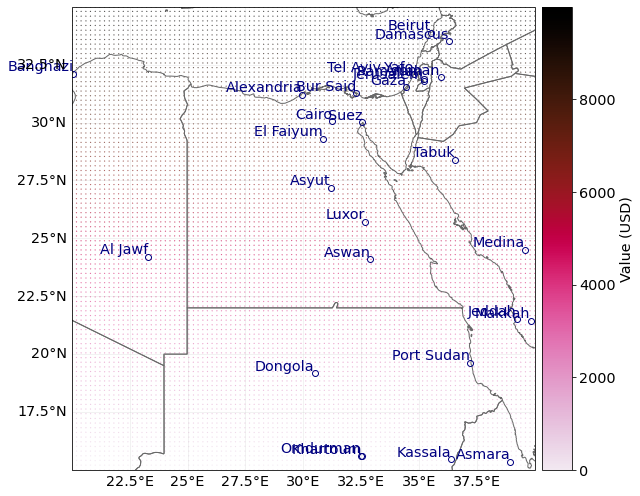

In [21]:
# Example 1: plot_hexbin method
print('\x1b[1;03;30;30m' + 'Plotting exp_df.' + '\x1b[0m')
axs = exp.plot_hexbin();

# further methods to check out:
# axs.set_xlim(15, 45) to modify x-axis borders, axs.set_ylim(10, 40) to modify y-axis borders
# further keyword arguments to play around with: pop_name, buffer, gridsize, ...

<GeoAxesSubplot:>

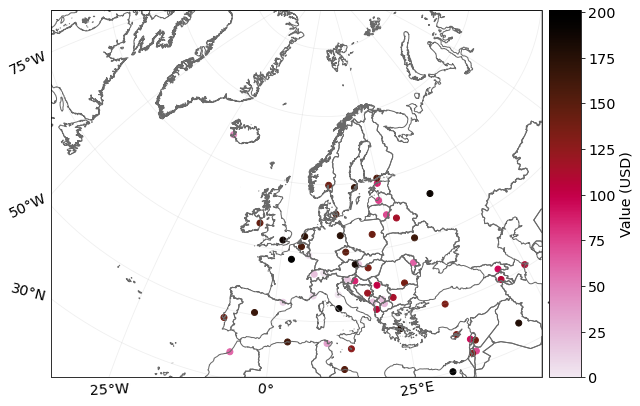

In [22]:
# Example 2: plot_scatter method

exp_gpd.to_crs('epsg:3035', inplace=True)
exp_gpd.plot_scatter(pop_name=False);

2021-06-04 17:07:42,654 - climada.util.coordinates - INFO - Raster from resolution 0.20202020202019355 to 0.20202020202019355.


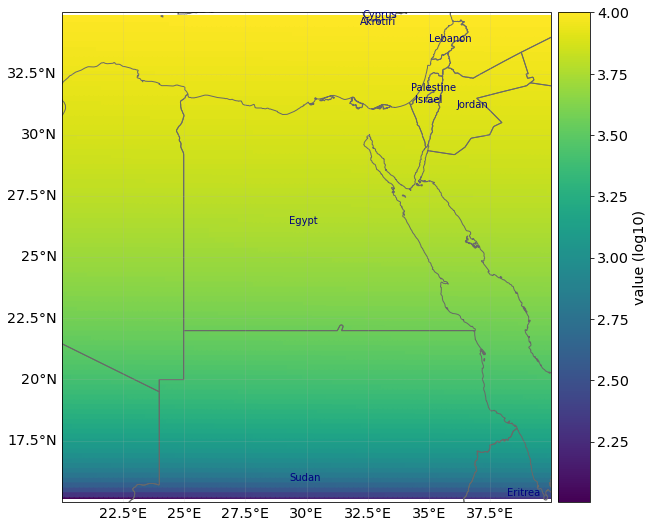

In [23]:
# Example 3: plot_raster method
from climada.util.plot import add_cntry_names # use climada's plotting utilities
ax = exp.plot_raster(); # plot with same resolution as data
add_cntry_names(ax, [exp.gdf.longitude.min(), exp.gdf.longitude.max(), exp.gdf.latitude.min(), exp.gdf.latitude.max()])

# use keyword argument save_tiff='filepath.tiff' to save the corresponding raster in tiff format
# use keyword argument raster_res='desired number' to change resolution of the raster.

2023-10-27 12:39:22,471 - climada.entity.exposures.base - INFO - Setting latitude and longitude attributes.
2023-10-27 12:39:23,214 - climada.entity.exposures.base - INFO - Setting latitude and longitude attributes.
2023-10-27 12:39:23,219 - climada.entity.exposures.base - INFO - Setting latitude and longitude attributes.
2023-10-27 12:39:23,910 - climada.entity.exposures.base - INFO - Setting latitude and longitude attributes.


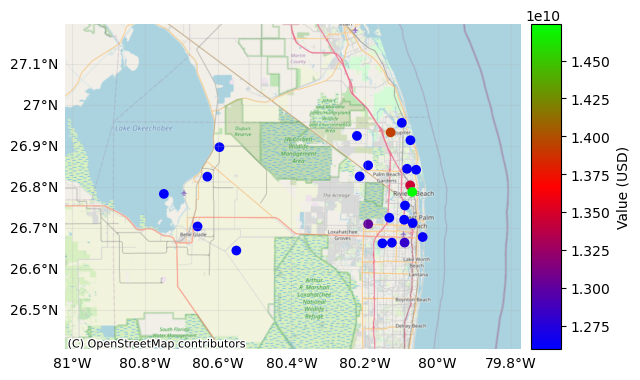

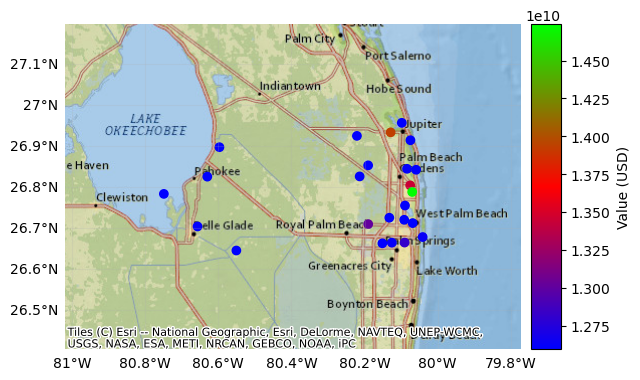

In [42]:
# Example 4: plot_basemap method
import contextily as ctx
# select the background image from the available ctx.providers
ax = exp_templ.plot_basemap(buffer=30000, cmap='brg'); # using open street map
ax = exp_templ.plot_basemap(buffer=30000, cmap='brg',
                            url=ctx.providers.Esri.NatGeoWorldMap,  # National Geographic's World map, 
                            zoom=9);  # select the zoom level of the map, affects the font size of labelled objects

Since `Exposures` is a `GeoDataFrame`, any function for visualization from geopandas can be used. Check [making maps](https://geopandas.readthedocs.io/en/latest/mapping.html#) and [examples gallery](http://geopandas.org/gallery/index.html).

array([[<AxesSubplot:title={'center':'value'}>]], dtype=object)

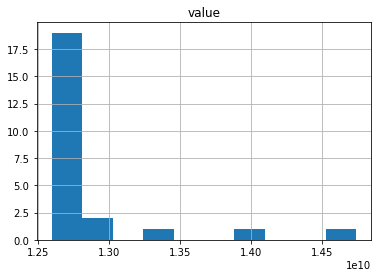

In [25]:
# other visualization types
exp_templ.gdf.hist(column='value');


## Write (Save) Exposures

Exposures can be saved in any format available for `GeoDataFrame` (see fiona.supported_drivers) and `DataFrame` ([pandas IO tools](https://pandas.pydata.org/pandas-docs/stable/io.html)). Take into account that in many of these formats the metadata (e.g. variables `ref_year` and `value_unit`) will not be saved. Use instead the format hdf5 provided by `Exposures` methods `write_hdf5()` and `from_hdf5()` to handle all the data.

In [26]:
import fiona; fiona.supported_drivers
from climada import CONFIG
results = CONFIG.local_data.save_dir.dir()

# DataFrame save to csv format. geometry writen as string, metadata not saved!
exp_templ.gdf.to_csv(results.joinpath('exp_templ.csv'), sep='\t')

In [27]:
# write as hdf5 file
exp_templ.write_hdf5(results.joinpath('exp_temp.h5'))

Finallly, as with any Python object, use climada's save option to save it in pickle format.

In [28]:
# save in pickle format
from climada.util.save import save
# this generates a results folder in the current path and stores the output there
save('exp_templ.pkl.p', exp_templ) # creates results folder and stores there


## Dask - improving performance for big exposure

Dask is used in some methods of CLIMADA and can be activated easily by proving the scheduler.

In [29]:
# set_geometry_points is expensive for big exposures
# for small amount of data, the execution time might be even greater when using dask
exp.gdf.drop(columns=['geometry'], inplace=True)
print(exp.gdf.head())
%time exp.set_geometry_points(scheduler='processes')
print(exp.gdf.head())

   value  latitude  longitude  impf_TC
0      0      15.0  20.000000        1
1      1      15.0  20.202020        1
2      2      15.0  20.404040        1
3      3      15.0  20.606061        1
4      4      15.0  20.808081        1
CPU times: user 243 ms, sys: 116 ms, total: 359 ms
Wall time: 2.52 s
   value  latitude  longitude  impf_TC                   geometry
0      0      15.0  20.000000        1  POINT (20.00000 15.00000)
1      1      15.0  20.202020        1  POINT (20.20202 15.00000)
2      2      15.0  20.404040        1  POINT (20.40404 15.00000)
3      3      15.0  20.606061        1  POINT (20.60606 15.00000)
4      4      15.0  20.808081        1  POINT (20.80808 15.00000)
